### 1. IMPORTING MODULES AND GETTING API STUFF(FOR DATA COLLECTION)

In [4]:
import pandas as pd
import oandapyV20
import oandapyV20.endpoints.instruments as instruments
from datetime import datetime, timedelta
import config

# OANDA API setup
API_TOKEN = config.API_TOKEN
ACCOUNT_ID = config.ACCOUNT_ID

client = oandapyV20.API(access_token=API_TOKEN)

### 2. USING OANDA TO GET DATA FOR BACKTESTING

In [5]:
# Function to fetch 5-minute candles
def fetch_candles(instrument, start_date, end_date, granularity="M5"):
    # Convert dates to the required ISO 8601 format
    start_date = datetime.strptime(start_date, "%Y-%m-%d")
    end_date = datetime.strptime(end_date, "%Y-%m-%d")
    delta = timedelta(days=1)

    candles = []
    while start_date < end_date:
        next_date = min(start_date + delta, end_date)
        params = {
            "from": start_date.isoformat(),
            "to": next_date.isoformat(),
            "granularity": granularity,
        }
        r = instruments.InstrumentsCandles(instrument=instrument, params=params)
        client.request(r)
        candles.extend(r.response["candles"])
        start_date = next_date
    
    # Parse the candles into a DataFrame
    data = []
    for candle in candles:
        time = candle["time"]
        o = float(candle["mid"]["o"])
        h = float(candle["mid"]["h"])
        l = float(candle["mid"]["l"])
        c = float(candle["mid"]["c"])
        v = int(candle["volume"])
        data.append([time, o, h, l, c, v])
    
    return pd.DataFrame(data, columns=["Time", "Open", "High", "Low", "Close", "Volume"])

# Fetch the data
data = fetch_candles(
    instrument="EUR_USD", 
    start_date="2024-11-1", 
    end_date="2024-11-30", 
    granularity="M5"
)

data


,Time,Open,High,Low,Close,Volume
0,2024-11-01T04:00:00.000000000Z,1.08763,1.08772,1.08759,1.08764,271
1,2024-11-01T04:05:00.000000000Z,1.08764,1.08770,1.08763,1.08768,381
2,2024-11-01T04:10:00.000000000Z,1.08768,1.08778,1.08768,1.08778,177
3,2024-11-01T04:15:00.000000000Z,1.08778,1.08782,1.08774,1.08780,234
4,2024-11-01T04:20:00.000000000Z,1.08782,1.08787,1.08778,1.08784,285
...,...,...,...,...,...,...
5958,2024-11-29T21:35:00.000000000Z,1.05792,1.05804,1.05779,1.05800,853
5959,2024-11-29T21:40:00.000000000Z,1.05800,1.05800,1.05784,1.05796,689
5960,2024-11-29T21:45:00.000000000Z,1.05796,1.05820,1.05793,1.05796,186
5961,2024-11-29T21:50:00.000000000Z,1.05796,1.05800,1.05752,1.05776,746



### 3. EXAMPLE STRAT FOR VISUALIZATION

In [15]:
def detect_sweeps_improved(df, length=5):
    """
    Improved sweep detector that more closely matches LuxAlgo's logic.
    
    Key improvements:
    - Maintains array of pivot points like LuxAlgo
    - Detects sweeps at the start of zones
    - Separate tracking for high/low pivots
    - Implements mitigation logic
    """
    
    signals = []
    pivot_highs = []  # Store pivot high points
    pivot_lows = []   # Store pivot low points
    
    # Initialize first bars
    for i in range(length + 1):
        signals.append(0)
    
    def is_pivot_high(window, mid_idx):
        """Check if the middle point is a pivot high"""
        mid_high = window.iloc[mid_idx]['High']
        left_section = window.iloc[:mid_idx]
        right_section = window.iloc[mid_idx+1:]
        return (mid_high > left_section['High'].max() and 
                mid_high > right_section['High'].max())
    
    def is_pivot_low(window, mid_idx):
        """Check if the middle point is a pivot low"""
        mid_low = window.iloc[mid_idx]['Low']
        left_section = window.iloc[:mid_idx]
        right_section = window.iloc[mid_idx+1:]
        return (mid_low < left_section['Low'].min() and 
                mid_low < right_section['Low'].min())
    
    # Main detection loop
    for i in range(length + 1, len(df)):
        current_candle = df.iloc[i]
        window = df.iloc[i-length-1:i]
        mid_idx = len(window) // 2
        
        signal = 0
        
        # Update pivot points
        if is_pivot_high(window, mid_idx):
            pivot_price = window.iloc[mid_idx]['High']
            pivot_highs.append({
                'price': pivot_price,
                'index': i-length//2,
                'active': True
            })
            
        if is_pivot_low(window, mid_idx):
            pivot_price = window.iloc[mid_idx]['Low']
            pivot_lows.append({
                'price': pivot_price,
                'index': i-length//2,
                'active': True
            })
        
        # Check for sweeps against active pivot points
        # Bearish sweeps
        for ph in pivot_highs:
            if ph['active']:
                if (current_candle['High'] > ph['price'] and 
                    current_candle['Close'] < ph['price']):
                    signal = 1
                    ph['active'] = False  # Deactivate after sweep
                elif current_candle['Close'] > ph['price']:
                    ph['active'] = False  # Mitigate if closed above
                    
        # Bullish sweeps
        for pl in pivot_lows:
            if pl['active']:
                if (current_candle['Low'] < pl['price'] and 
                    current_candle['Close'] > pl['price']):
                    signal = 2
                    pl['active'] = False  # Deactivate after sweep
                elif current_candle['Close'] < pl['price']:
                    pl['active'] = False  # Mitigate if closed below
        
        signals.append(signal)
        
        # Clean up old pivot points (older than 300 bars like LuxAlgo)
        pivot_highs = [ph for ph in pivot_highs if i - ph['index'] <= 300]
        pivot_lows = [pl for pl in pivot_lows if i - pl['index'] <= 300]
    
    return signals




# Apply to the dataset
data['signal'] = detect_sweeps_improved(data, length=5)

# Count signals
signal_counts = data['signal'].value_counts().sort_index()
print("\nSignal Counts:")
for signal_type in [0, 1, 2]:
    count = signal_counts.get(signal_type, 0)
    print(f"{signal_type}: {count}")

# Print some example sweeps for verification
print("\nExample Sweeps:")
sweep_examples = data[data['signal'] != 0].head(5)
for idx, row in sweep_examples.iterrows():
    signal_type = "Bearish" if row['signal'] == 1 else "Bullish"
    print(f"\nTime: {row['Time']}")
    print(f"Type: {signal_type} sweep")
    print(f"High: {row['High']:.5f}")
    print(f"Low: {row['Low']:.5f}")
    print(f"Close: {row['Close']:.5f}")


Signal Counts:
0: 5542
1: 200
2: 221

Example Sweeps:

Time: 2024-11-01 07:20:00+00:00
Type: Bearish sweep
High: 1.08775
Low: 1.08742
Close: 1.08773

Time: 2024-11-01 10:50:00+00:00
Type: Bearish sweep
High: 1.08590
Low: 1.08570
Close: 1.08584

Time: 2024-11-01 11:55:00+00:00
Type: Bearish sweep
High: 1.08694
Low: 1.08670
Close: 1.08679

Time: 2024-11-01 13:55:00+00:00
Type: Bullish sweep
High: 1.08711
Low: 1.08655
Close: 1.08699

Time: 2024-11-01 14:05:00+00:00
Type: Bullish sweep
High: 1.08650
Low: 1.08566
Close: 1.08642



### 4. VISUALIZATION OF STRAT

/Users/rikhil/opt/anaconda3/lib/python3.9/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+
/var/folders/99/ftwg1jqj6k58stth5w5svqcm0000gp/T/ipykernel_91574/3764513339.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


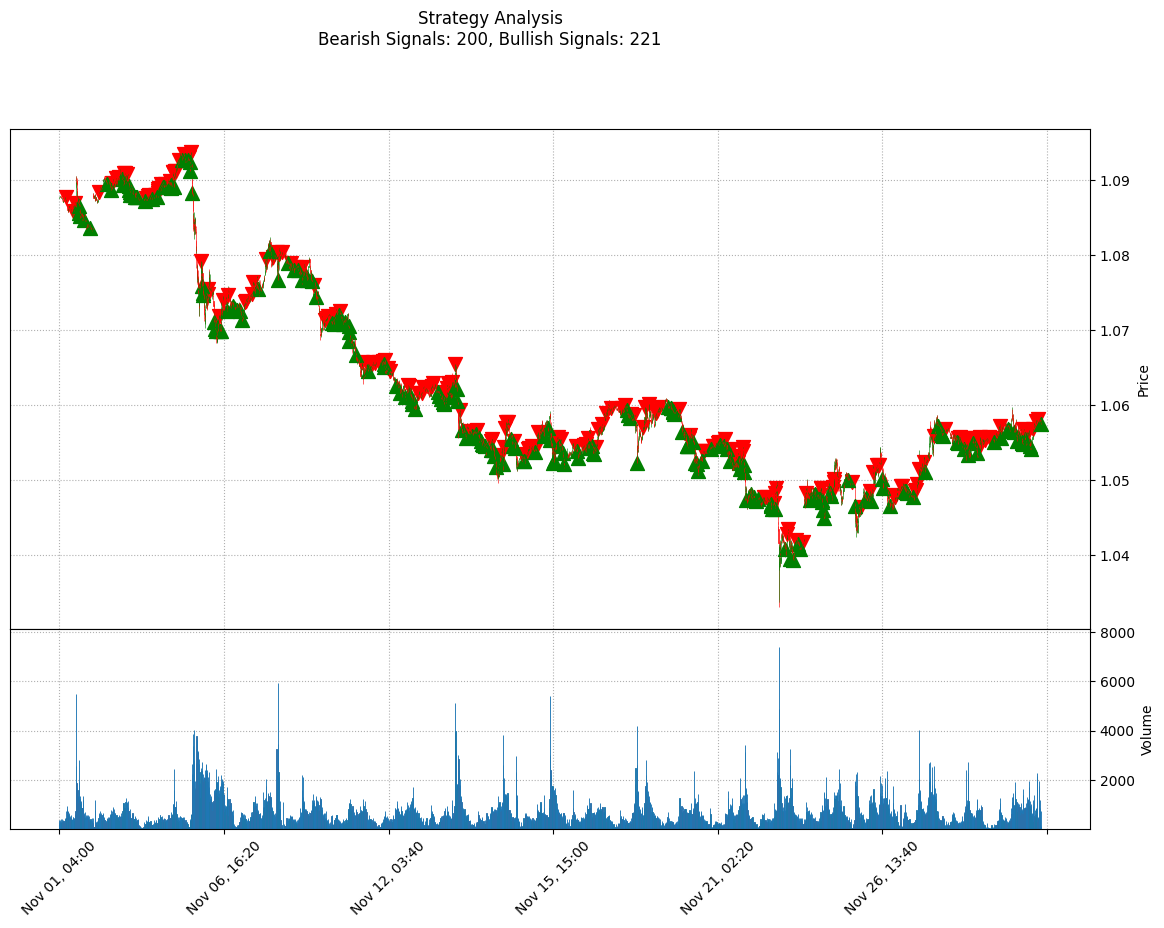


Sweep Statistics:
--------------------
No Signal (0): 5542
Bearish Sweeps (1): 200
Bullish Sweeps (2): 221

Sweep Performance Metrics:
---------------------------------------------
Bearish Sweeps: 50.0% win rate, -0.0 pips avg movement
Bullish Sweeps: 46.4% win rate, -0.8 pips avg movement


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np

def plot_signals(data, title_prefix="Strategy Analysis", marker_params=None):
    """
    Generic plotter for any strategy signals
    
    Parameters:
    data (DataFrame): DataFrame with OHLCV data and 'signal' column
    title_prefix (str): Prefix for the chart title
    marker_params (dict): Optional custom marker parameters like:
        {
            'bearish': {'marker': 'v', 'color': 'red', 'size': 100},
            'bullish': {'marker': '^', 'color': 'green', 'size': 100}
        }
    """
    if marker_params is None:
        marker_params = {
            'bearish': {'marker': 'v', 'color': 'red', 'size': 100},
            'bullish': {'marker': '^', 'color': 'green', 'size': 100}
        }
    
    data = data.copy()
    data['Time'] = pd.to_datetime(data['Time'])
    data = data.set_index('Time')
    
    # Create marker data arrays
    bearish_data = pd.Series(index=data.index, data=np.nan)
    bullish_data = pd.Series(index=data.index, data=np.nan)
    
    # Fill in marker points
    bearish_data[data['signal'] == 1] = data['High'][data['signal'] == 1]
    bullish_data[data['signal'] == 2] = data['Low'][data['signal'] == 2]
    
    # Create plot with markers
    apdict = [
        mpf.make_addplot(bearish_data, type='scatter',
                        marker=marker_params['bearish']['marker'],
                        markersize=marker_params['bearish']['size'],
                        color=marker_params['bearish']['color']),
        mpf.make_addplot(bullish_data, type='scatter',
                        marker=marker_params['bullish']['marker'],
                        markersize=marker_params['bullish']['size'],
                        color=marker_params['bullish']['color'])
    ]
    
    # Style configuration
    mc = mpf.make_marketcolors(
        up='green', down='red',
        edge='inherit', wick='inherit',
        volume='in'
    )
    
    style = mpf.make_mpf_style(
        marketcolors=mc,
        gridstyle=':',
        y_on_right=True
    )
    
    # Create title with signal counts
    signal_counts = data['signal'].value_counts()
    bearish_count = signal_counts.get(1, 0)
    bullish_count = signal_counts.get(2, 0)
    title = f'{title_prefix}\nBearish Signals: {bearish_count}, Bullish Signals: {bullish_count}'
    
    fig, axes = mpf.plot(
        data,
        type='candle',
        style=style,
        title=title,
        volume=True,
        figsize=(15, 10),
        addplot=apdict,
        returnfig=True
    )
    
    plt.tight_layout()
    return fig, axes


# Create the plot
fig, axes = plot_signals(data)
plt.show()

# Print statistics
print("\nSweep Statistics:")
print("-" * 20)
sweep_counts = data['signal'].value_counts().sort_index()
print(f"No Signal (0): {sweep_counts.get(0, 0)}")
print(f"Bearish Sweeps (1): {sweep_counts.get(1, 0)}")
print(f"Bullish Sweeps (2): {sweep_counts.get(2, 0)}")

# Calculate win rate and average movement
def calculate_sweep_metrics(data, periods=5):
    """Calculate metrics for sweeps"""
    movements = {'Bearish': [], 'Bullish': []}
    wins = {'Bearish': 0, 'Bullish': 0}
    total = {'Bearish': 0, 'Bullish': 0}
    
    for i in range(len(data) - periods):
        if data['signal'].iloc[i] == 1:  # Bearish sweep
            start_price = data['Close'].iloc[i]
            end_price = data['Close'].iloc[i + periods]
            movement = (end_price - start_price) * 10000  # Convert to pips
            movements['Bearish'].append(movement)
            total['Bearish'] += 1
            if movement < 0:  # Price went down = win for bearish
                wins['Bearish'] += 1
                
        elif data['signal'].iloc[i] == 2:  # Bullish sweep
            start_price = data['Close'].iloc[i]
            end_price = data['Close'].iloc[i + periods]
            movement = (end_price - start_price) * 10000  # Convert to pips
            movements['Bullish'].append(movement)
            total['Bullish'] += 1
            if movement > 0:  # Price went up = win for bullish
                wins['Bullish'] += 1
    
    return movements, wins, total

movements, wins, total = calculate_sweep_metrics(data)

print("\nSweep Performance Metrics:")
print("-" * 45)
if total['Bearish'] > 0:
    win_rate_bearish = (wins['Bearish'] / total['Bearish']) * 100
    avg_move_bearish = np.mean(movements['Bearish'])
    print(f"Bearish Sweeps: {win_rate_bearish:.1f}% win rate, {avg_move_bearish:.1f} pips avg movement")

if total['Bullish'] > 0:
    win_rate_bullish = (wins['Bullish'] / total['Bullish']) * 100
    avg_move_bullish = np.mean(movements['Bullish'])
    print(f"Bullish Sweeps: {win_rate_bullish:.1f}% win rate, {avg_move_bullish:.1f} pips avg movement")